### **0. References**

### **1. Libraries**

In [1]:
# Standard Library imports
import os
import pathlib
import random
import time
from collections import Counter
import copy

# Third-Party Library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Scikit-learn imports
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, random_split

# Torchvision import
from torchvision import transforms

# Additional libraries
import timm


c:\Users\Admin\anaconda3\envs\TCCT\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## GPU check and torch version check ##
!nvidia-smi --query-gpu=name,memory.total --format=csv,noheader
print( 'torch version : ',torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'



NVIDIA GeForce RTX 4070 Ti SUPER, 16376 MiB
torch version :  2.5.1+cu121


### **2. general utils**

In [37]:
def plot_training_metrics(flag,train_losses, train_accuracies, val_losses, val_accuracies):
    
    if flag :
        train_losses = train_losses[:len(train_losses)-5]
        val_losses = val_losses[:len(val_losses)-5]
        train_accuracies = train_accuracies[:len(train_accuracies)-5]
        val_accuracies = val_accuracies[:len(val_accuracies)-5]
    
    epochs = range(1, len(train_losses) + 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Loss Curve
    axes[0].plot(epochs, train_losses, label='Train Loss', color='blue', linestyle='-')
    axes[0].plot(epochs, val_losses, label='Validation Loss', color='red', linestyle='-')
    axes[0].set_title('Loss vs Epochs', fontsize=14)
    axes[0].set_xlabel('Epochs', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].legend(fontsize=12)
    axes[0].grid(True, linestyle='--', linewidth=0.5)
    
    # Accuracy Curve
    axes[1].plot(epochs, train_accuracies, label='Train Accuracy ( Top 1 )', color='blue', linestyle='-')
    axes[1].plot(epochs, val_accuracies, label='Validation Accuracy ( Top 1 )', color='red', linestyle='-')
    axes[1].set_title('Accuracy ( Top 1 ) vs Epochs', fontsize=14)
    axes[1].set_xlabel('Epochs', fontsize=12)
    axes[1].set_ylabel('Accuracy ( Top 1 )', fontsize=12)
    axes[1].legend(fontsize=12)
    axes[1].grid(True, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

def get_class_distribution(dataset, class_to_idx):
    """Returns the class distribution as a sorted dictionary by class names"""
    idx_to_class = {v: k for k, v in class_to_idx.items()}  # Reverse mapping
    labels = [label.item() for _, label in dataset]  # Extract labels
    class_counts = Counter(labels)  # Count occurrences

    return {idx_to_class[k]: class_counts[k] for k in sorted(class_counts.keys(), key=lambda x: idx_to_class[x])}


def display_dataset_info(train_dataset, val_dataset, test_dataset):
    class_to_idx = test_dataset.class_to_idx   
    datasets = {
        "Train": train_dataset,
        "Validation": val_dataset,
        "Test": test_dataset
    }
    combined_info = []
    for name, dataset in datasets.items():
        size = len(dataset)
        shape = dataset[0][0].shape
        dtype = dataset[0][0].dtype
        shape_info = f"{shape}, dtype: {dtype}"
        dist = get_class_distribution(dataset, class_to_idx)
        combined_info.append({
            "Dataset": name,
            "Shape and DataType": shape_info,
            "#no_substruct": dist.get("no", 0),
            "#sphere_substruct": dist.get("sphere", 0),
            "#vort_substruct": dist.get("vort", 0),
            'Total images': size
        })
    df = pd.DataFrame(combined_info)
    return df

def print_random_images(dataset):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    indices = [random.randint(0, 2499), random.randint(2500, 4999), random.randint(5000, 7499)]
    for ax, idx in zip(axes, indices):
        img, _ = dataset[idx] # (1,224,224) torch tensor
        img = img.numpy()
        img = img.squeeze(0)
        ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(dataset.paths[idx].parent.name+' substructure', fontsize=12)
    plt.tight_layout()
    plt.show()

def set_seed(seed):
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True # only applies to CUDA convolutional operation.
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.use_deterministic_algorithms(True,warn_only=True)

def ROC_AUC_curves(all_labels, all_probs, class_names=None):  
    num_classes = all_probs.shape[1]
    all_labels_onehot = np.eye(num_classes)[all_labels]

    # Dictionaries to hold FPR, TPR, and AUC for each class
    fpr, tpr, roc_auc = {}, {}, {}

    # Set up figure parameters for high quality
    plt.figure(figsize=(8, 6), dpi=300)
    plt.rc('font', family='serif', size=12)

    # Manually define a visually appealing color palette
    colors = ['crimson','navy', 'purple', 'forestgreen', 'purple', 'crimson', 'teal', 'gold', 'brown', 'magenta', 'deepskyblue']

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_onehot[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        label = f'{class_names[i]}' if class_names else f'Class {i}'
        plt.plot(fpr[i], tpr[i], color=colors[i % len(colors)], lw=2.5,
                 label=f'{label} (AUC = {roc_auc[i]:.3f})')
        print(f"{label} AUC: {roc_auc[i]:.4f}")

    # Plot diagonal chance line
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', alpha=0.8)

    # Axes limits, labels, and title
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve - One vs. Rest', fontsize=16, fontweight='bold')

    # Customize legend
    plt.legend(loc="lower right", fontsize=11, frameon=True, shadow=True)

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(r'figures\roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()




### **3. Dataset utils**

In [4]:
def find_classes(directory):
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

class CustomDataset(Dataset): # inherits from torch.utils.data.Dataset class
    def __init__(self, target_dir, transform=None):
        self.paths = list(pathlib.Path(target_dir).rglob('*/*.npy')) # get all the paths of
        # files in the target directory's subdirectories.
        self.transform = transform
        self.classes,self.class_to_idx = find_classes(target_dir)
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        img_path = self.paths[index]
        img = np.load(img_path) 
        img = torch.tensor(img, dtype=torch.float32)
        class_name = img_path.parent.name # get the parent directory name of the image
        label = torch.tensor(self.class_to_idx[class_name],dtype=torch.int64)

        if self.transform:
            img = self.transform(img)
        
        return img, label 

### **4. Training utils**

In [5]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
        elif self.best_loss - val_loss >= self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0
            self.status = f"Improvement found, counter reset to {self.counter}"
        else:
            self.counter += 1
            self.status = f"No improvement in the last {self.counter} epochs"
            if self.counter >= self.patience:
                self.status = f"\nEarly stopping triggered after {self.counter} epochs. Restoring best weights ......."
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True
        return False

class Trainer:
    def __init__(self, model, device, HP ,verbose=1):
        self.model = model
        self.device =device
        self.epochs = HP['num_epochs']
        self.batch_size = HP['batch_size']
        self.lr = HP['lr']
        self.weight_decay = HP['weight_decay']
        self.verbose = verbose
    
    ## inference_one_epoch ##
    def inference_one_epoch(self,val_loader,criterion):

        self.model.eval()
        
        correct_validation = 0
        total_validation = 0
        running_val_loss = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_validation += labels.size(0)
                correct_validation += (predicted == labels).sum().item()
        
        val_loss = running_val_loss / len(val_loader)
        val_accuracy = 100 * correct_validation / total_validation

        return val_loss,val_accuracy


    ## train_one_epoch ##
    def train_one_epoch(self,train_loader,optimizer,criterion):
        
        self.model.train()
        
        start_time = time.time()
        running_loss = 0.0
        correct_train, total_train = 0, 0
        
        for images,labels in tqdm(train_loader):

            images = images.to(self.device)  
            labels = labels.to(self.device)
                
            optimizer.zero_grad()
            outputs = self.model(images) # (B,3)
            
            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs,dim=1) # (B,1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100 * correct_train / total_train
        epoch_time = time.time()-start_time
        
        return epoch_loss, epoch_acc, epoch_time
    
    ## trainer ##
    def model_train(self,train_loader,val_loader):

        optimizer = torch.optim.Adam(self.model.parameters(), lr = self.lr, weight_decay= self.weight_decay)
        criterion = nn.CrossEntropyLoss()
        es = EarlyStopping(patience=5, min_delta=0, restore_best_weights=True)
        flag = False 

        train_losses, train_accuracies, val_losses, val_accuracies = [],[],[],[]

        for epoch in range(self.epochs):

            # training
            train_loss, train_acc, epoch_time = self.train_one_epoch(train_loader,optimizer,
                                                    criterion)
            
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            if self.verbose in [1,2]:
                print(f'epoch [{epoch+1}/{self.epochs}], train_loss: {train_loss:.4f}, train_accuracy ( Top 1 ): {train_acc:.2f}%, Time:{epoch_time:.2f} seconds')   
            
            # validating
            val_loss, val_acc = self.inference_one_epoch(val_loader,criterion)
            
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if self.verbose in [1,2]:
                print(f'validation_loss: {val_loss:.4f}, validation_accuracy ( Top 1 ): {val_acc:.2f}%')
            
            # early stopping    
            if es(self.model,val_loss):
                print(es.status)
                flag = True 
                break

        if self.verbose in [1,3]:
            plot_training_metrics(flag,train_losses,train_accuracies,val_losses,val_accuracies)


### **5. TRAINING and INFERENCE**

In [6]:
## Data directories and 'key' hyperparameters ##

## TO-CHANGE CELL START ##
train_dir = r'C:\Users\Admin\Desktop\GSOC\datasets\dataset-deeplense-common-test\train'
test_dir = r'C:\Users\Admin\Desktop\GSOC\datasets\dataset-deeplense-common-test\val'

HP = {
    'lr' : 0.001,
    'batch_size' : 16,
    'num_epochs' : 25,
    'weight_decay' : 0,
    'dropout' : 0.1,
    'random_num' : 1345
}

train_ratio = 0.85
val_ratio = 0.15    
## TO-CHANGE CELL END ##

##### **5.1 Data Visualization and loading**

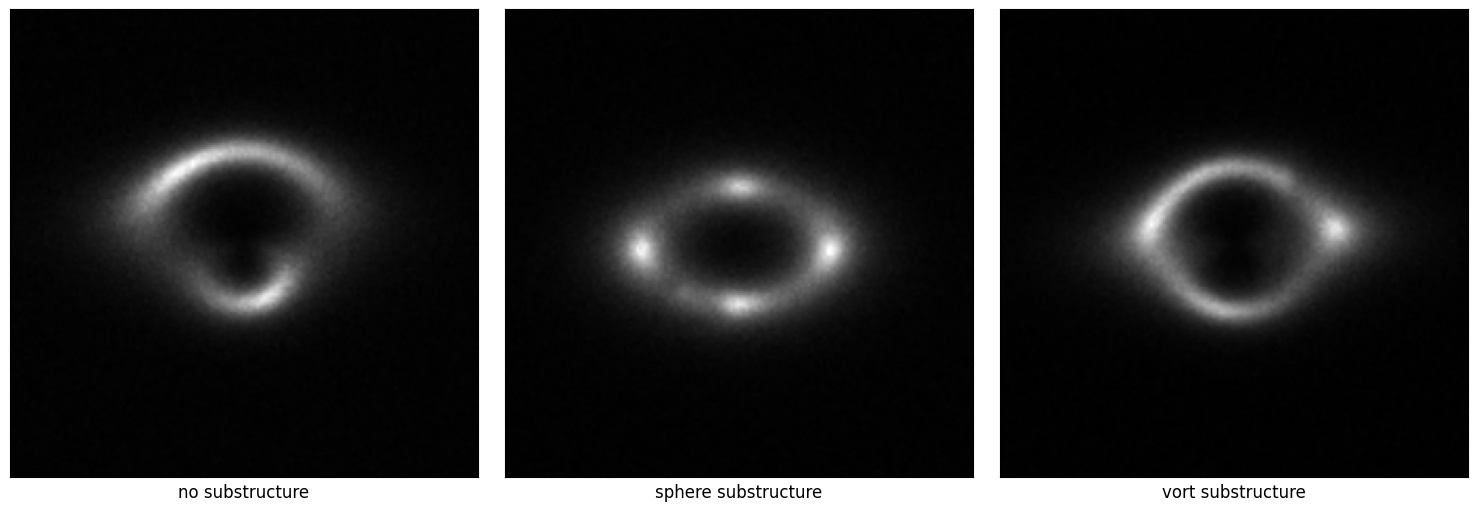

,Dataset,Shape and DataType,#no_substruct,#sphere_substruct,#vort_substruct,Total images
0,Train,"torch.Size([1, 224, 224]), dtype: torch.float32",8469,8488,8543,25500
1,Validation,"torch.Size([1, 224, 224]), dtype: torch.float32",1531,1512,1457,4500
2,Test,"torch.Size([1, 224, 224]), dtype: torch.float32",2500,2500,2500,7500


In [7]:
## DATA LOADING ##
set_seed(HP['random_num'])  # for having the same train-val split every time.

train_mean = 0.458 # ( calculated sepertely )
train_std = 0.150 # ( calculated sepertely )

transform = transforms.Compose([
    transforms.Resize((224,224)), # Input torch.tensor([C,H,W]) => torch.tensor([C,224,224])   
    transforms.Lambda(lambda x: 2*x - 1), # min-max normalization to [-1,1]
])

# Note : The resizing operation is purely spatial interpolation. Hence, even if the pixel values 
# are normalized, the resizing operation can be performed.


train_val_dataset = CustomDataset(train_dir, transform=transform)
test_dataset = CustomDataset(test_dir, transform=transform)

train_size = int(train_ratio * len(train_val_dataset))
val_size   = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=HP['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=HP['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=HP['batch_size'], shuffle=False)

## DATA VISUALIZATION ##

# Displaying random images for each class in the dataset
print_random_images(test_dataset)
# Note : data is min-max normalized hence the printed image is not exactly the true image.

# Displaying dataset information like total number of images, class distribution, etc.
display_dataset_info(train_dataset, val_dataset, test_dataset)


##### **5.2 Defining Model**

In [8]:
## MODEL LOADING ##
    
class PretrainedModel(nn.Module):
    def __init__(self, config, num_classes=3):
        super(PretrainedModel, self).__init__()
        # Create the backbone without the original classifier
        self.backbone = timm.create_model(
            config,
            pretrained=True,
            num_classes=3,  
            in_chans=1,
            drop_rate=0.1
        )
        
    def forward(self, x):
        # x: (B,1,224,224) 
        logits = self.backbone(x) # (B,3)
        return logits



##### **5.3 Training Model**

Total trainable parameters : 11.17 M


100%|██████████| 1594/1594 [01:00<00:00, 26.32it/s]


epoch [1/25], train_loss: 1.0182, train_accuracy ( Top 1 ): 43.24%, Time:60.57 seconds
validation_loss: 0.7794, validation_accuracy ( Top 1 ): 64.71%


100%|██████████| 1594/1594 [00:59<00:00, 26.86it/s]


epoch [2/25], train_loss: 0.5082, train_accuracy ( Top 1 ): 79.63%, Time:59.35 seconds
validation_loss: 0.5666, validation_accuracy ( Top 1 ): 80.44%


100%|██████████| 1594/1594 [00:58<00:00, 27.08it/s]


epoch [3/25], train_loss: 0.3304, train_accuracy ( Top 1 ): 87.70%, Time:58.86 seconds
validation_loss: 0.3165, validation_accuracy ( Top 1 ): 88.42%


100%|██████████| 1594/1594 [00:59<00:00, 26.82it/s]


epoch [4/25], train_loss: 0.2639, train_accuracy ( Top 1 ): 90.36%, Time:59.42 seconds
validation_loss: 0.2747, validation_accuracy ( Top 1 ): 89.71%


100%|██████████| 1594/1594 [00:59<00:00, 26.94it/s]


epoch [5/25], train_loss: 0.2205, train_accuracy ( Top 1 ): 92.01%, Time:59.16 seconds
validation_loss: 0.2955, validation_accuracy ( Top 1 ): 89.38%


100%|██████████| 1594/1594 [00:59<00:00, 26.78it/s]


epoch [6/25], train_loss: 0.1910, train_accuracy ( Top 1 ): 93.15%, Time:59.52 seconds
validation_loss: 0.2571, validation_accuracy ( Top 1 ): 91.24%


100%|██████████| 1594/1594 [00:59<00:00, 26.87it/s]


epoch [7/25], train_loss: 0.1690, train_accuracy ( Top 1 ): 93.94%, Time:59.33 seconds
validation_loss: 0.3015, validation_accuracy ( Top 1 ): 88.64%


100%|██████████| 1594/1594 [00:59<00:00, 26.91it/s]


epoch [8/25], train_loss: 0.1496, train_accuracy ( Top 1 ): 94.72%, Time:59.23 seconds
validation_loss: 0.2357, validation_accuracy ( Top 1 ): 91.84%


100%|██████████| 1594/1594 [00:40<00:00, 38.88it/s]


epoch [9/25], train_loss: 0.1300, train_accuracy ( Top 1 ): 95.39%, Time:41.00 seconds
validation_loss: 0.3326, validation_accuracy ( Top 1 ): 90.02%


100%|██████████| 1594/1594 [00:37<00:00, 42.02it/s]


epoch [10/25], train_loss: 0.1126, train_accuracy ( Top 1 ): 96.01%, Time:37.94 seconds
validation_loss: 0.3065, validation_accuracy ( Top 1 ): 90.58%


100%|██████████| 1594/1594 [00:37<00:00, 42.37it/s]


epoch [11/25], train_loss: 0.0955, train_accuracy ( Top 1 ): 96.61%, Time:37.63 seconds
validation_loss: 0.2101, validation_accuracy ( Top 1 ): 93.09%


100%|██████████| 1594/1594 [00:37<00:00, 42.45it/s]


epoch [12/25], train_loss: 0.0824, train_accuracy ( Top 1 ): 97.01%, Time:37.55 seconds
validation_loss: 0.3685, validation_accuracy ( Top 1 ): 86.60%


100%|██████████| 1594/1594 [00:36<00:00, 43.18it/s]


epoch [13/25], train_loss: 0.0729, train_accuracy ( Top 1 ): 97.38%, Time:36.91 seconds
validation_loss: 0.2663, validation_accuracy ( Top 1 ): 92.80%


100%|██████████| 1594/1594 [00:37<00:00, 43.03it/s]


epoch [14/25], train_loss: 0.0611, train_accuracy ( Top 1 ): 97.89%, Time:37.04 seconds
validation_loss: 0.2905, validation_accuracy ( Top 1 ): 91.71%


100%|██████████| 1594/1594 [00:37<00:00, 42.42it/s]


epoch [15/25], train_loss: 0.0566, train_accuracy ( Top 1 ): 98.05%, Time:37.58 seconds
validation_loss: 0.3053, validation_accuracy ( Top 1 ): 91.71%


100%|██████████| 1594/1594 [00:37<00:00, 43.05it/s]


epoch [16/25], train_loss: 0.0504, train_accuracy ( Top 1 ): 98.22%, Time:37.03 seconds
validation_loss: 0.3362, validation_accuracy ( Top 1 ): 91.18%

Early stopping triggered after 5 epochs. Restoring best weights .......


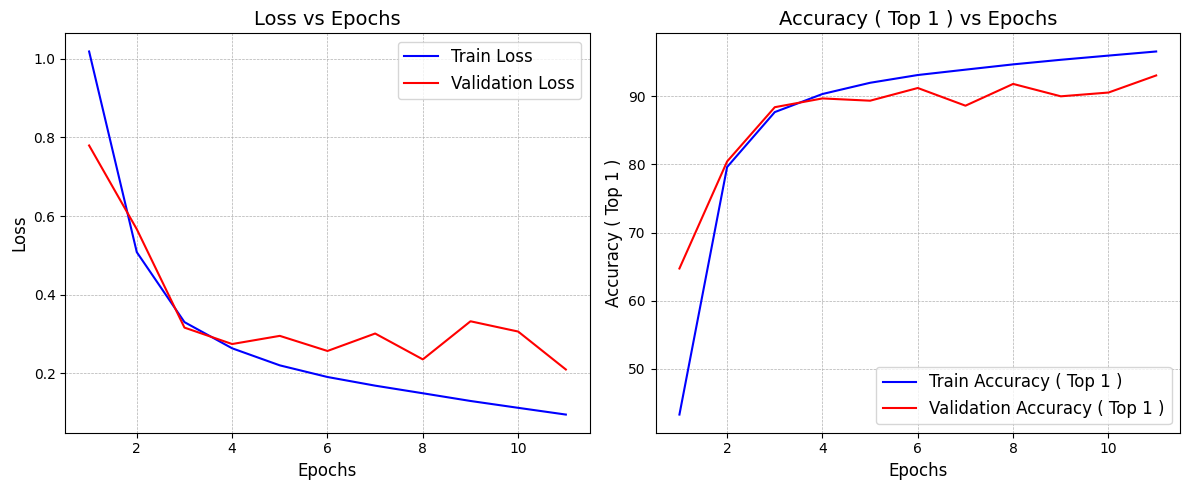

In [9]:
## TRAINING ##
set_seed(HP['random_num'])   # for having the same initial weights every time. 
config = 'resnet18'
model = PretrainedModel(config).to(device)

# total training parameters in the model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6 # in millions    
print(f'Total trainable parameters : {total_params:.2f} M')

# training the model    
trainer = Trainer(model,device,HP)
trainer.model_train(train_loader,val_loader)

##### **5.4 Inference on Test dataset**

Test Accuracy ( Top 1 ): 92.51 % 

Confusion Matrix:
[[2404   65   31]
 [ 156 2198  146]
 [  58  106 2336]] 

Class 0 AUC: 0.9906
Class 1 AUC: 0.9787
Class 2 AUC: 0.9902


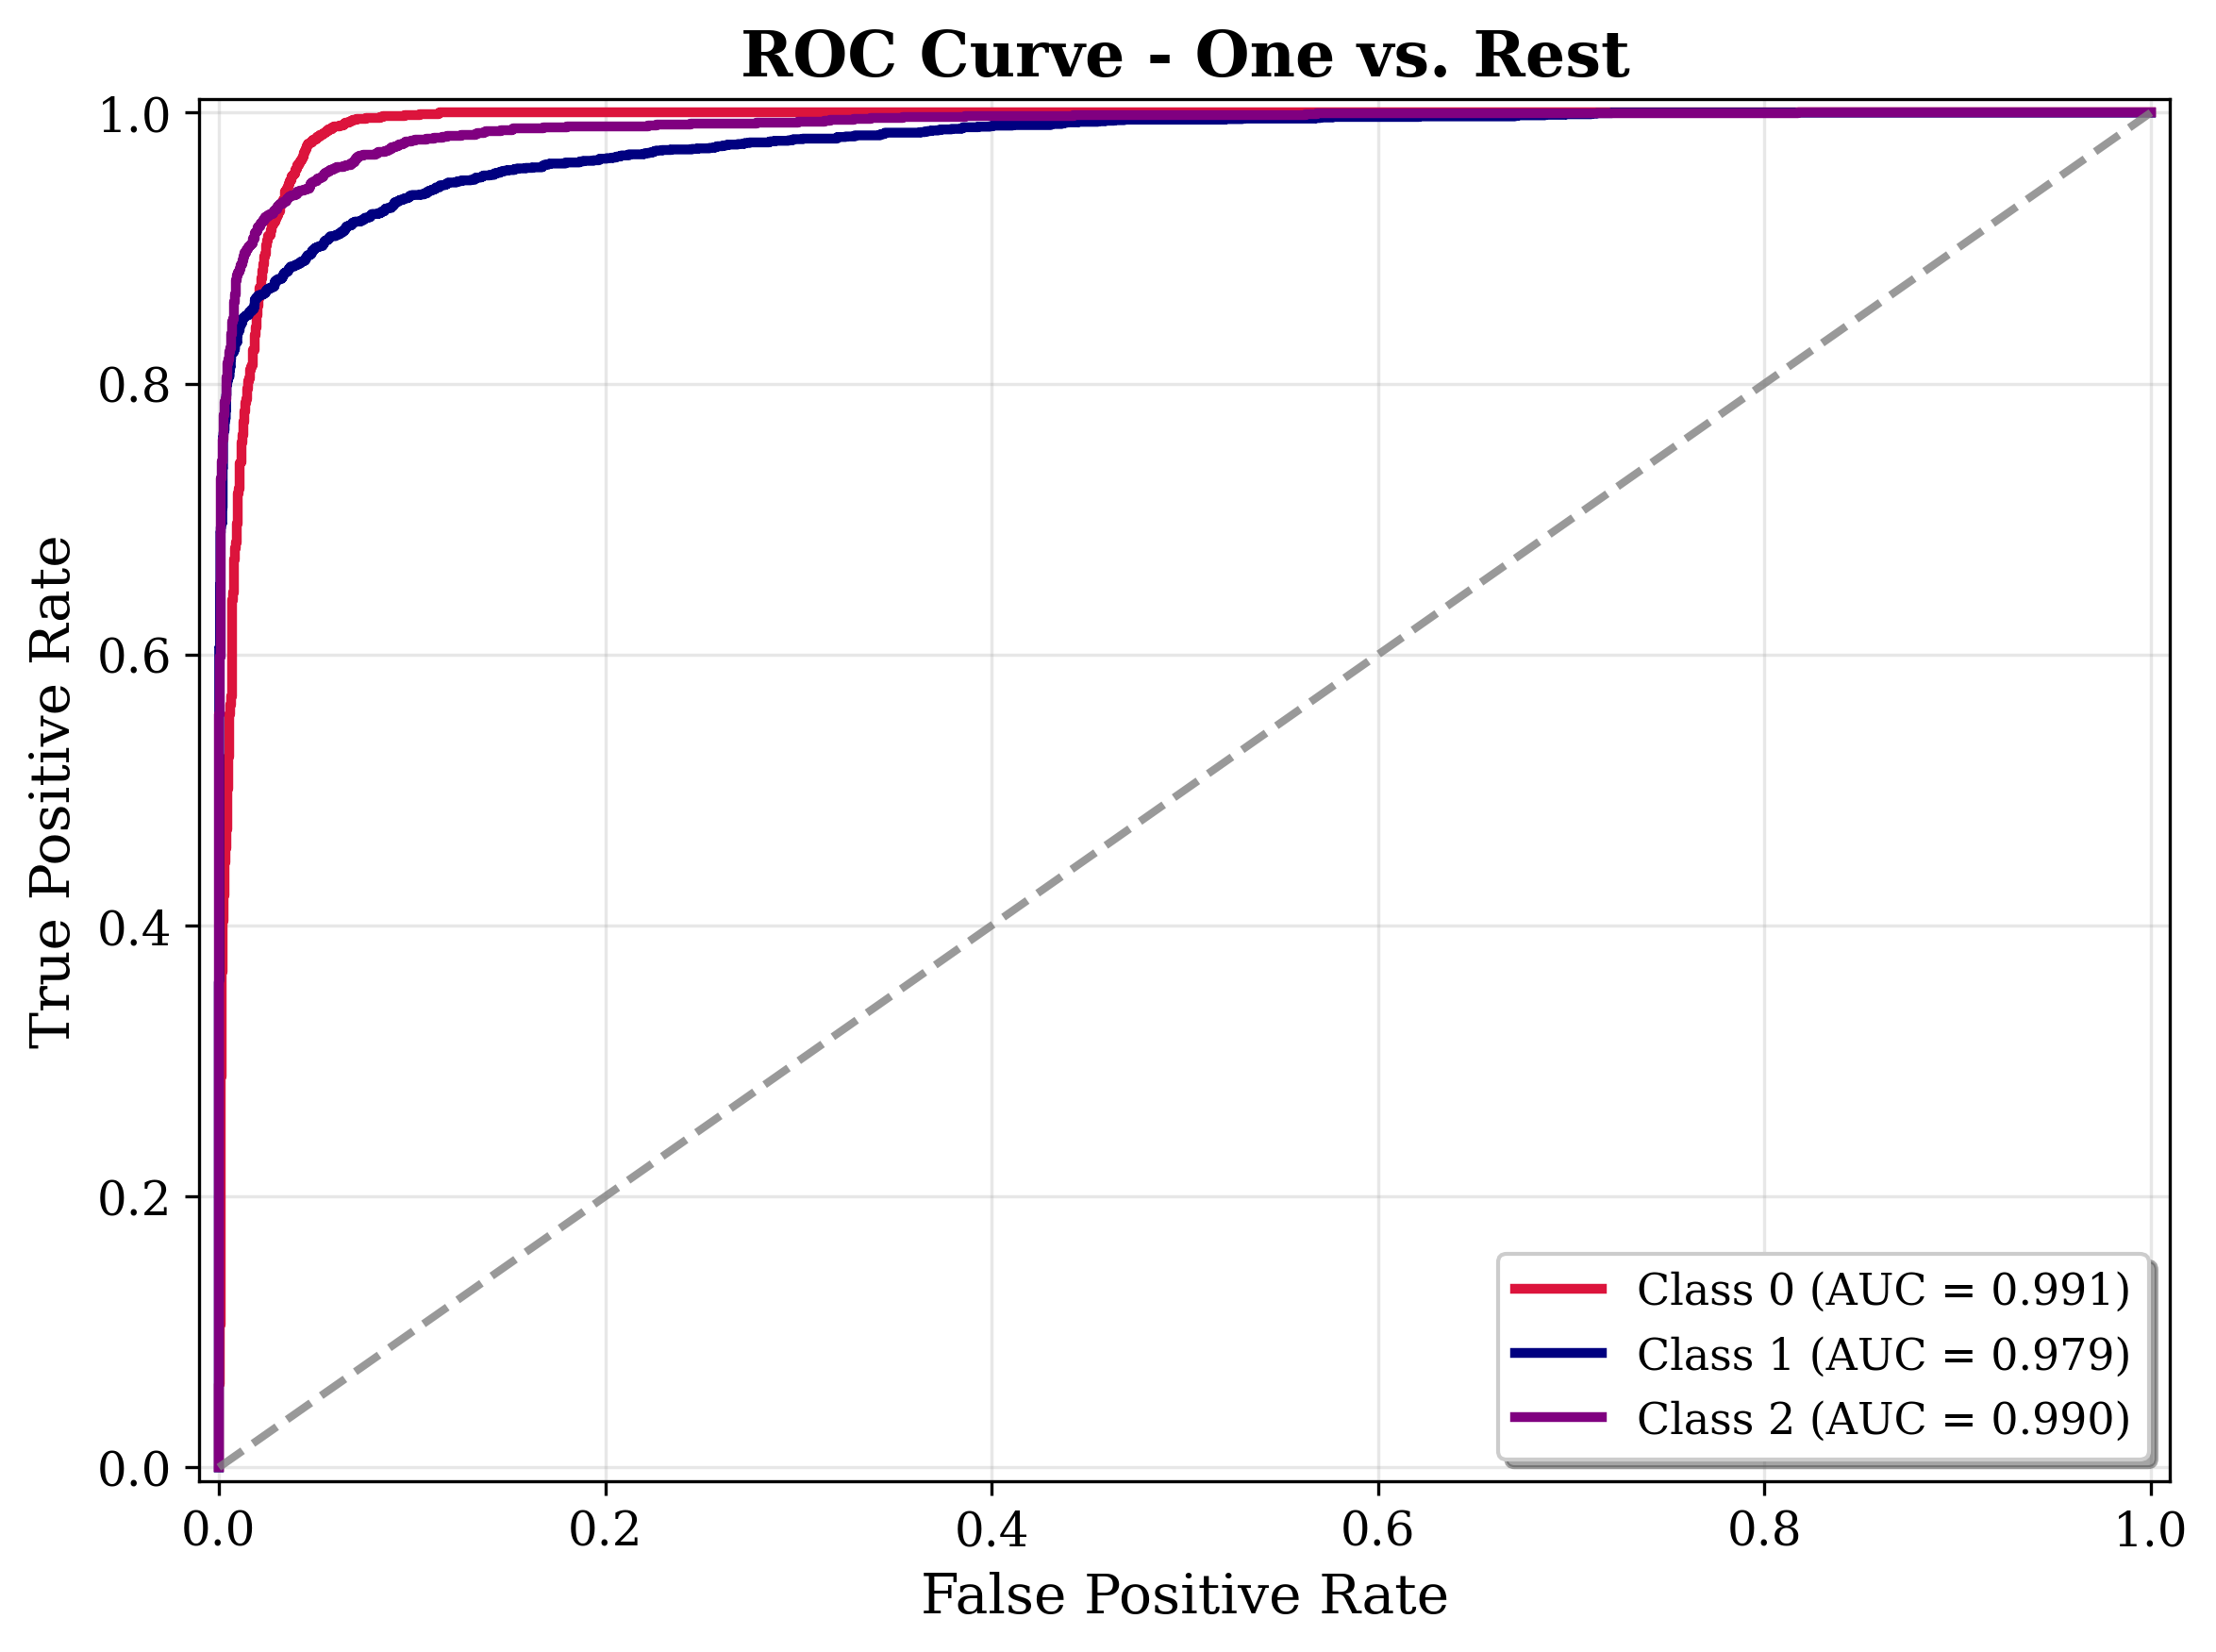

In [39]:


# --- Inference and Data Collection ---
model.eval()
all_preds = []
all_labels = []
all_probs = []  # probabilities for ROC calculation

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)  # (B, num_classes)
        _, predicted = torch.max(outputs, dim=1) # (B,)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Obtain softmax probabilities
        probs = F.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds) # (N,)
all_labels = np.array(all_labels) # (N,)
all_probs = np.array(all_probs) # (N, num_classes)

# Compute and print overall accuracy
accuracy = 100 * np.mean(all_preds == all_labels)
print(f"Test Accuracy ( Top 1 ): {accuracy:.2f} % ")

# Compute confusion matrix (optional)
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm,'\n')

# --- ROC Curve Calculation per Class ---

ROC_AUC_curves(all_labels,all_probs)
